In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from osgeo import gdal, ogr, gdal_array
import dask
import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry
import os
#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools, BandIndices, DEADataHandling
from load_data import load_data
from transform_tuple import transform_tuple
from query_from_shp import query_from_shp
from rsgislib.segmentation import segutils
from rasterstats import zonal_stats
from imageSeg import imageSeg
import fiona
import rasterio.features

In [3]:
# where is your data and results folder?
results = "results/"
data = 'data/'

sensors = ['ls5','ls7','ls8']

#are we using a polygon to mask the AOI?
shp_fpath = 'data/spatial/PeelR_AOI_Claire.shp'

#Input your area of interest's name, coords, and 
#the year you're interested in?
AOI = 'Peel_randomForest'
year = '2013'

time_period = ('2015-10-15', '2015-03-31')

#What thresholds should I use?
threshold = 0.8
wofs_theshold = 0.15
#-----------------------------------------

In [4]:
#Creating a folder to keep things neat
directory = results + AOI + "_" + year
if not os.path.exists(directory):
    os.mkdir(directory)

results = results + AOI + "_" + year + "/"

In [5]:
#set up query
query = query_from_shp(shp_fpath, time_period[0], time_period[1], dask_chunks = 1000)
#landsat
# dc = datacube.Datacube(app='dc_name')
# landsat = DEADataHandling.load_clearlandsat(dc,query=query, sensors=sensors, product='nbart',
#                        masked_prop=0.75)

landsat = load_data(dc_name = 'irrigated_areas', sensors=sensors,
          export_name = data + AOI + "_" + year + '.nc', query=query)
#wofs
dc = datacube.Datacube(app='wofs')
del query['time'] 
wofs_alltime = dc.load(product = 'wofs_summary', **query)

#masking the returned array to the polygon area
with fiona.open(shp_fpath) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

mask = rasterio.features.geometry_mask([geom.to_crs(landsat.geobox.crs) for geoms in [geom]],
                                           out_shape=landsat.geobox.shape,
                                           transform=landsat.geobox.affine,
                                           all_touched=False,
                                           invert=True)
# Mask the xarrays
landsat = landsat.where(mask)
#wofs_alltime = wofs_alltime.where(mask)
#datacube.storage.storage.write_dataset_to_netcdf(landsat, results + AOI "_" + year + '.nc')

ls5_loading...
ls5_loaded
ls7_loading...


src/load_data.py:24: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not landsat_ds:


ls7_loaded


src/load_data.py:24: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not landsat_ds:


ls8_loading...
ls8_loaded


src/load_data.py:24: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not landsat_ds:
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/indexing.py:1199: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


In [8]:
#band indices calculation
def ndvi_func(nir, red):
    return ((nir - red)/(nir + red))

def ndvi_ufunc(ds):
    return xr.apply_ufunc(
        ndvi_func, ds.nir, ds.red,
        dask='parallelized',
        output_dtypes=[float])

# def brightness_func(g,r,nir,swir):
#     return (g**2 + r**2 + nir**2 + swir**2)**(1/2.0)

# def brightness_ufunc(ds):
#     return xr.apply_ufunc(
#         brightness_func, ds.green,ds.red, ds.nir, ds.swir1,
#         dask='parallelized',
#         output_dtypes=[float])

NDVI_landsat = ndvi_ufunc(landsat)
# NDMI_landsat = BandIndices.calculate_indices(landsat, index='NDMI-nir')
# brightness_landsat = brightness_ufunc(landsat)

print('resampling timeseries')
NDVI_landsat = NDVI_landsat.resample(time='M').mean('time')
y = NDVI_landsat.coords['y']
x = NDVI_landsat.coords['x']

#calculate per pixel summary stats
print('calculating stats')
NDVI_max = NDVI_landsat.max('time').rename('NDVI_max')
NDVI_mean = NDVI_landsat.mean('time').rename('NDVI_mean')
NDVI_std = NDVI_landsat.std('time').rename('NDVI_std')
NDVI_min = NDVI_landsat.min('time').rename('NDVI_min')
NDVI_range = NDVI_max - NDVI_min
NDVI_range = NDVI_range.rename('NDVI_range')

timeofmax = NDVI_landsat.values.argmax(axis=0)
timeofmax = xr.DataArray(timeofmax, coords = [y, x], dims = ['y', 'x'], name='time_of_max')

timeofmin = NDVI_landsat.values.argmin(axis=0)
timeofmin = xr.DataArray(timeofmin, coords = [y, x], dims = ['y', 'x'], name='time_of_min')

# NDMI_max = NDMI_landsat.max('time').rename('NDMI_max')
# NDMI_mean = NDMI_landsat.mean('time').rename('NDMI_mean')
# NDMI_std = NDMI_landsat.std('time').rename('NDMI_std')
# NDMI_min = NDMI_landsat.min('time').rename('NDMI_min')
# brightness_max = brightness_landsat.max('time').rename('brightness_max')
# brightness_mean = brightness_landsat.mean('time').rename('brightness_mean')
# brightness_std = brightness_landsat.std('time').rename('brightness_std')
# brightness_min = brightness_landsat.min('time').rename('brightness_min')

resampling timseries
calculating stats


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [9]:
xray_list = [NDVI_max, NDVI_mean, NDVI_std, NDVI_min, NDVI_range,timeofmax, timeofmin]
names = ['NDVI_max', 'NDVI_mean', 'NDVI_std', 'NDVI_min', 'NDVI_range','timeofmax', 'timeofmin']

# ds_list = []
# for i, j in zip(xray_list, names):
#     x = i.to_dataset(name=j).chunk({'x':1000, 'y':1000})
#     ds_list.append(x)

# aoi_params = xr.merge(ds_list)
# aoi_params.attrs=dict(crs=landsat.crs)

### Image segmentation for use in masking AFTER the RF classifier

In [10]:
#export Gtiff for use in Image segmentation
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
SpatialTools.array_to_geotiff(results + AOI + "_" + year + "ndvimax.tif",
              NDVI_max.values, geo_transform = transform, 
              projection = projection, nodata_val=np.nan)

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [11]:
InputNDVIStats = results + AOI + "_" + year + "ndvimax.tif"
KEAFile = results + AOI + '_' + year + '.kea'
SegmentedKEAFile = results + AOI + '_' + year + '_sheperdSEG.kea'
SegmentedTiffFile = results + AOI + '_' + year + '_sheperdSEG.tif'
SegmentedPolygons = results + AOI + '_' + year + '_SEGpolygons.shp'
imageSeg(InputNDVIStats, KEAFile, SegmentedKEAFile, SegmentedTiffFile, SegmentedPolygons, minPxls = 100)

Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.
Mask stretched Image.
Deleting file: ./Peel_randomForest_2013_stchdonly.kea
Deleting file: ./Peel_randomForest_2013_stchdonlyOff.kea
Deleting file: ./Peel_randomForest_2013_stchdmaskonly.kea
Performing KMeans.
Apply KMeans to image.
Eliminate Single Pixels.
Perform clump.
Eliminate small pixels.
Relabel clumps.
Calculate image statistics and build pyramids.
Deleting file: ./Peel_randomForest_2013_kmeansclusters.gmtxt
Deleting file: ./Peel_randomForest_2013_kmeans.kea.aux.xml
Deleting file: ./Peel_randomForest_2013_kmeans.kea
Deleting file: ./Peel_randomForest_2013_kmeans_nosgl.kea
Deleting file: ./Peel_randomForest_2013_kmeans_nosglTMP.kea
Deleting file: ./Peel_randomForest_2013_clumps.kea
Deleting file: ./Peel_randomForest_2013_clumps_elim.kea
Deleting file: ./Peel_randomForest_2013_stchd.kea


### Generate a training dataset

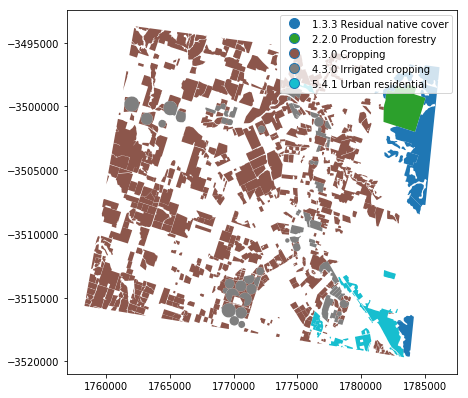

In [12]:
peel_landuse = gpd.read_file('data/spatial/Peel_landuse_small.shp')
peel_landuse = peel_landuse.to_crs(epsg=3577)

peel_trainset = peel_landuse[(peel_landuse.TertiaryAL == 430) | #irrigated cropping
                        (peel_landuse.TertiaryAL == 330) |      #cropping
                        (peel_landuse.TertiaryAL == 220) |      #forestry
                        (peel_landuse.TertiaryAL == 133) |      #native cover (bushland)
                        (peel_landuse.TertiaryAL == 541)]       #urban

peel_trainset = peel_trainset[['TertiaryAL', 'd_Tertiary', 'geometry']]
peel_trainset.columns = ['id', 'class', 'geometry']
peel_trainset.to_file(results + AOI + "_" + year + "_peel_trainset.shp")
peel_trainset.plot(column = 'class', legend=True, figsize=(7,7))

In [13]:
#rasterize the training dataset
NDVI_max = xr.open_rasterio(results + AOI + "_" + year + "ndvimax.tif")
NDVI_max = NDVI_max.squeeze()
#get the transform and projection of our gtiff
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
#find the width and height of the xarray dataset we want to mask
width,height = NDVI_max.shape
# rasterize vector
training_set = SpatialTools.rasterize_vector(results + AOI + "_" + year + "_peel_trainset.shp",
               height, width, transform, projection, field='id',raster_path= results + AOI + "_" + year +'training_raster.tif')
#xr.DataArray(training_set, coords = [NDVI_max.y, NDVI_max.x], dims = ['y', 'x'], name='training areas').plot(figsize=(10,10))

Exporting raster to results/Peel_randomForest_2013/Peel_randomForest_2013training_raster.tif


In [14]:
classes = np.unique(training_set)
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,n=(training_set == c).sum()))

Class 0 contains 12300787 pixels
Class 133 contains 33519 pixels
Class 220 contains 13736 pixels
Class 330 contains 261158 pixels
Class 430 contains 35214 pixels
Class 541 contains 14946 pixels


### Classify using random forest

In [15]:
# Read in our training data
roi_ds = gdal.Open(results + AOI + "_" + year +'training_raster.tif', gdal.GA_ReadOnly)
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint16)
#convert to numpy arrays (SLOW BECAUSE DASK ARRAYS ARE COMPUTED)
x,y = NDVI_max.shape
z = len(xray_list)
img = np.zeros((x,y,z))
for b,c in zip(xray_list, range(img.shape[2])):
    print('adding slice to array...')
    img[:, :, c] = b.values 
    
img_noNaNs = np.nan_to_num(img) #remove nans as they f/w classifier

adding slice to array...


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


adding slice to array...
adding slice to array...


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/dask/array/reductions.py:381: RuntimeWarning: invalid value encountered in true_divide
  u = total / n


adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...


Text(0.5, 1.0, 'AOI Training Data')

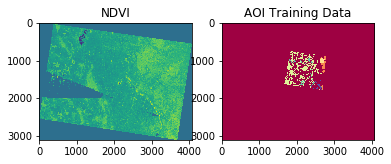

In [16]:
# # Display them
plt.subplot(121)
plt.imshow(img_noNaNs[:, :, 1])
plt.title('NDVI')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('AOI Training Data')

In [17]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
x = img_noNaNs[roi > 0,:]
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=x.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 358573 samples
The training data include 5 classes: [133 220 330 430 541]
Our X matrix is sized: (358573, 7)
Our y array is sized: (358573,)


In [18]:
from sklearn.ensemble import RandomForestClassifier
# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True, verbose=True)

# Fit our model to training data
rf = rf.fit(x, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  9.5min finished


In [19]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 90.1495650815873%


In [20]:
#disaply the importance of the individual bands
for b, imp in zip(names, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band NDVI_max importance: 0.1656311443691543
Band NDVI_mean importance: 0.242783649184443
Band NDVI_std importance: 0.1494289347520895
Band NDVI_min importance: 0.23660937787780273
Band NDVI_range importance: 0.11822551818253517
Band timeofmax importance: 0.04036544950304198
Band timeofmin importance: 0.04695592613093366


In [21]:
# Create a cross-tabulation dataframe to check out how each class performs
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(x)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


predict    133    220     330    430    541     All
truth                                              
133      33519      0       0      0      0   33519
220          0  13736       0      0      0   13736
330          0      0  261157      1      0  261158
430          0      0       5  35209      0   35214
541          0      0       0      0  14946   14946
All      33519  13736  261162  35210  14946  358573


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   45.7s finished


In [22]:
# Take our full image, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img_noNaNs.shape[0] * img_noNaNs.shape[1], img_noNaNs.shape[2])

img_as_array = img_noNaNs[:, :, :z].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img_noNaNs.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
print('generating prediction')
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img_noNaNs[:, :, 0].shape)

Reshaped from (3115, 4064, 7) to (12659360, 7)
generating prediction


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 21.0min finished


Text(0.5, 1.0, 'Irrigation Pixels Only')

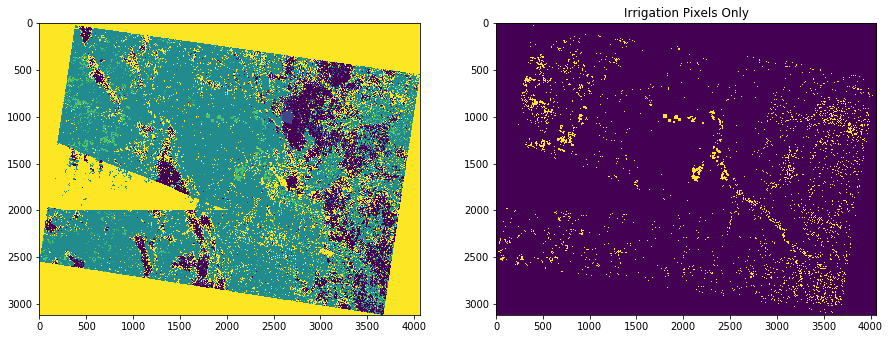

In [23]:
#generate a plot of the predictions
import matplotlib.patches as mpatches
values = np.unique(class_prediction.ravel())

plt.figure(figsize=(15,15))
plt.subplot(121)
im = plt.imshow(class_prediction, interpolation='none')
# colors = [im.cmap(im.norm(value)) for value in values]
# patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.subplot(122)
irr = np.where(class_prediction==430, 1, 0)
plt.imshow(irr)
plt.title('Irrigation Pixels Only')

In [43]:
#export out the results
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
SpatialTools.array_to_geotiff(results + AOI + "_" + year + "classpredict.tif",
              class_prediction, geo_transform = transform, 
              projection = projection, nodata_val=0)

### use image segmentation polygons to filter results of RF

In [25]:
class_predict = xr.open_rasterio(results + AOI + "_" + year + "classpredict.tif")
class_predict = class_predict.squeeze()

gdf = gpd.read_file(results + AOI + '_' + year + '_SEGpolygons.shp')
#calculate majority values inside segments
gdf['majority'] = pd.DataFrame(zonal_stats(vectors=gdf['geometry'], raster=results + AOI + "_" + year + "classpredict.tif", stats='majority'))['majority']
#calculate area of polygons
gdf['area'] = gdf['geometry'].area
#filter by area and majority values
smallArea = gdf['area'] <= 5500000
irrigated = gdf['majority'] == 430.0 #filtering for irrigated areas only
gdf = gdf[smallArea&irrigated]
#export shapefile
gdf.to_file(results + AOI + "_" + year + "_Irrigated.shp")

#get the transform and projection of our gtiff
transform, projection = transform_tuple(class_predict, (class_predict.x, class_predict.y), epsg=3577)
#find the width and height of the xarray dataset we want to mask
width,height = class_predict.shape
# rasterize vector
gdf_raster = SpatialTools.rasterize_vector(results + AOI + "_" + year + "_Irrigated.shp",
                                           height, width, transform, projection, raster_path=results + AOI + "_" + year + "_Irrigated.tif")

Exporting raster to results/Peel_randomForest_2013/Peel_randomForest_2013_Irrigated.tif


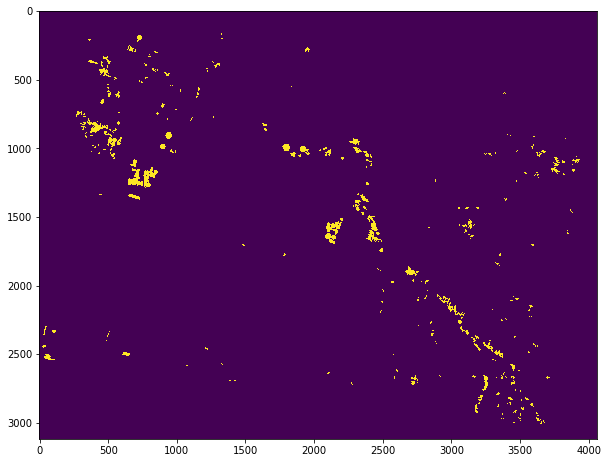

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(gdf_raster, interpolation='none')